# Разделимость данных

Примените алгоритмы уменьшения размерности к данным из предыдущей лабораторной, объясните полученные результаты

1. С помощью любого из рассмотренных на лекциях алгоритмов снижения размерности спроецируйте тренировочные данные в 2d пространство. Визуализируйте результаты снижения размерности. Цветом обозначьте категорию объекта
1. Примените алгоритм кластеризации к спроецированным данным. Расчитайте средние внутрикластерное и межкласторное расстояния получившейся проекции
1. Опишите результаты 

In [1]:
import numpy as np
import pandas as pd

# Визуализация

import seaborn as sns
import matplotlib.pyplot as plt

# Датасеты
from sklearn.datasets import load_iris  # для классификации
from sklearn.datasets import load_boston  # для регрессии

# Utils
from sklearn.model_selection import train_test_split, cross_val_score

# Модели (классификация)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Модели (регрессия)
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score  # для классификации
from sklearn.metrics import mean_absolute_error, mean_squared_error  # для регрессии

# Misc
from sklearn.manifold import TSNE

plt.style.use('dark_background')

%matplotlib inline

In [2]:
tb = pd.read_csv('../4/anon_gps_tracks_with_dive.csv')
# tb = tb.drop(columns=[1])
tb.set_index(tb.iloc[:, 0])
tb.reset_index(drop = True, inplace = True)
tb.head(5)

,Unnamed: 0,lat,lon,alt,unix,bird,species,year,date_time,max_depth.m,colony2,coverage_ratio,is_dive,is_dive_1m,is_dive_2m,is_dive_4m,is_dive_5m,is_dive_0m
0,1,56.095451,-6.233089,-23.059999,1340627854,1,tCOGU,t2012,2012-06-25 13:37:34,-2.172046,1,0.5,False,False,False,False,False,False
1,2,56.095408,-6.233520,-2.983077,1340627954,1,tCOGU,t2012,2012-06-25 13:39:14,-1.152306,1,0.6,False,False,False,False,False,False
2,3,56.095437,-6.234275,3.470286,1340628054,1,tCOGU,t2012,2012-06-25 13:40:54,-2.172046,1,0.7,False,False,False,False,False,False
3,4,56.095635,-6.234815,1.902667,1340628154,1,tCOGU,t2012,2012-06-25 13:42:34,-2.172046,1,0.8,False,False,False,False,False,False
4,5,56.095821,-6.235293,2.824952,1340628254,1,tCOGU,t2012,2012-06-25 13:44:14,-2.172046,1,0.9,False,False,False,False,False,False


In [3]:
tb['birdId'] = tb.colony2 * 2**32 + tb.bird
tb.sort_values(['birdId', 'unix'], inplace=True)
tb['dxy'] = tb.lon.diff() ** 2 + tb.lat.diff() ** 2
tb.loc[tb.birdId != tb.birdId.shift(), 'dxy'] = 0

In [4]:
groups = tb.groupby(tb.birdId)

cols = {}

lat = groups.lat
lon = groups.lon

cols['lonlat'] = np.sqrt((lat.max() - lat.min()) ** 2 + (lon.max() - lon.min()) ** 2)
cols['lonlat2'] = lon.mean() + lat.mean()
# cols['lonlat3'] = np.maximum(lat.std(), lon.std())
cols['depth'] = groups['max_depth.m'].max()
cols['dist'] = groups.dxy.sum()

mn = tb['max_depth.m'].min()
cols['depth?'] = groups['max_depth.m'].median() - mn + 1
# cols['alt'] = groups['alt'].median()

df = pd.DataFrame(cols)

X = df.to_numpy()

df['target'] = groups.species.first()

y = groups.species.first().to_numpy()

df.head(5)

,lonlat,lonlat2,depth,dist,depth?,target
birdId,,,,,,
4294967297,0.180058,49.854447,71.249234,0.001260,10.17766,tCOGU
4294967298,0.639549,49.941130,17.203014,0.047685,11.19740,tRAZO
4294967299,0.731191,50.088686,13.124054,0.063483,10.17766,tRAZO
4294967300,0.393973,49.981723,13.124054,0.084937,10.17766,tRAZO
4294967301,0.243992,49.922211,65.130794,0.005366,11.19740,tCOGU


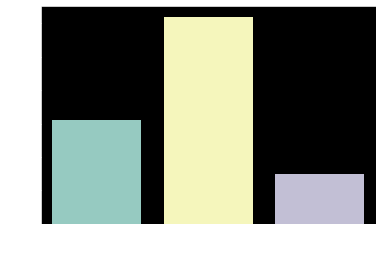

In [5]:
sns.countplot(x='target', data=df);

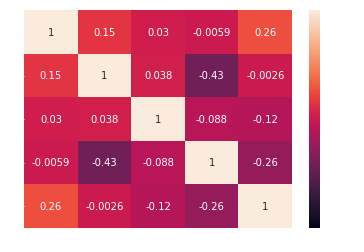

In [6]:
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True);

In [7]:
from sklearn import datasets
from sklearn.manifold import TSNE

possible_targets = list(set(df.target))
few_colors_list = [(1, 0, 0, 1), (0, 1, 0, 1), (0.5, 0.5, 1, 1), (1, 1, 0, 1), (1, 0, 1, 1), (0, 1, 1, 1), (1, 1, 1, 1)]
colors = dict(zip(possible_targets, few_colors_list))
c=list(map(colors.__getitem__, y))
print(colors)

{'tCOGU': (1, 0, 0, 1), 'tRAZO': (0, 1, 0, 1), 'tEUSH': (0.5, 0.5, 1, 1)}


In [8]:
def set_figsize():
    plt.figure(figsize=(14,12))
def process_method(m):
    X_reduced = m(X)
    set_figsize()
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=c, s=100, edgecolor="k")
    plt.show()
    return X_reduced

x:\python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


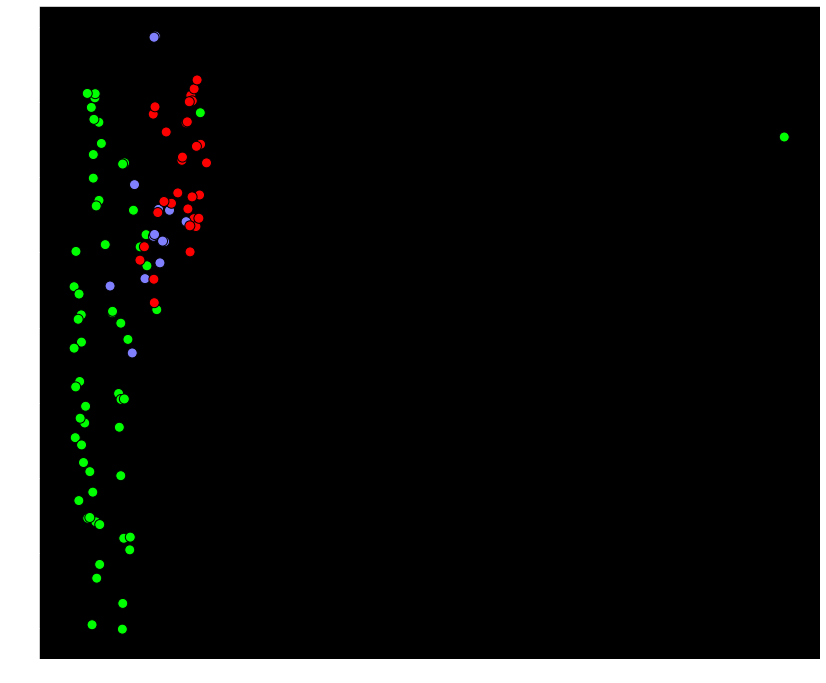

In [9]:
process_method(lambda x: TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(x));

In [10]:
import umap
def do_umap(x):
    reducer = umap.UMAP(n_neighbors=8, min_dist = 0.3, random_state=0)
    reducer.fit(x)
    X_reduced = reducer.transform(X)
    assert(np.all(X_reduced == reducer.embedding_))
    return X_reduced

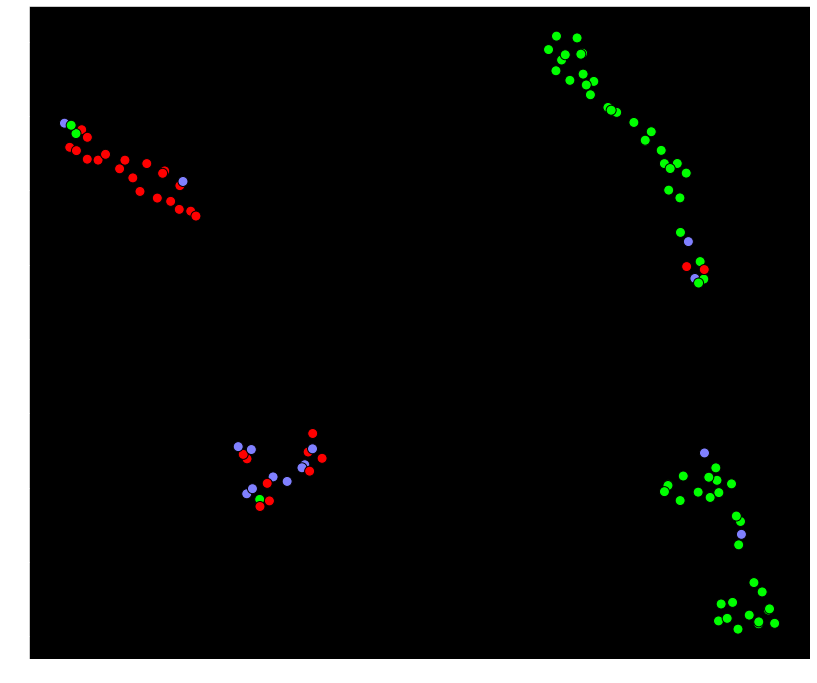

In [11]:
X_reduced = process_method(do_umap)

In [12]:
from sklearn.cluster import KMeans

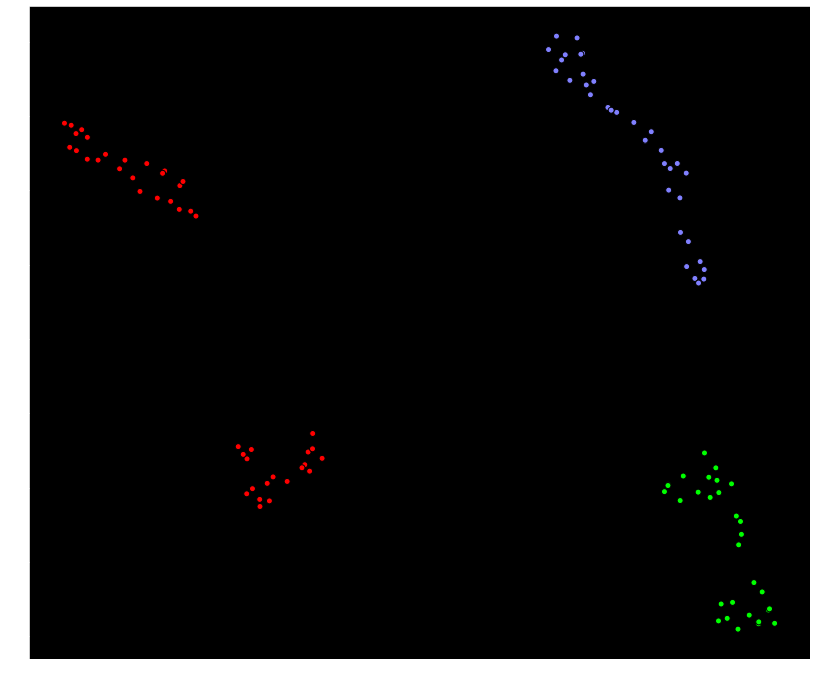

In [13]:
km = KMeans(n_clusters=3, random_state=0)
y_pred = km.fit_predict(X_reduced)
# centroids = km.cluster_centers_

kmeanscolors = dict(zip(list(set(y_pred)), few_colors_list))
kmeansc = list(map(kmeanscolors.__getitem__, y_pred))

set_figsize()
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeansc, edgecolor='k')
plt.show();

In [14]:
# http://www.machinelearning.ru/wiki/images/archive/2/28/20150427184336%21Voron-ML-Clustering-slides.pdf#page=14
sum_eq = 0
cnt_eq = 0
sum_neq = 0
cnt_neq = 0

n = len(y_pred)
for i in range(n):
    ypi = y_pred[i]
    xri = X_reduced[i]
    for j in range(i + 1, n):
        ypj = y_pred[j]
        xrj = X_reduced[j]
        dist = np.linalg.norm(xrj - xri)
        if ypi == ypj:
            sum_eq += dist
            cnt_eq += 1
        else:
            sum_neq += dist
            cnt_neq += 1

print("Same cluster distance:", sum_eq / cnt_eq)
print("Diff cluster distance:", sum_neq / cnt_neq)

Same cluster distance: 3.811414588166645
Diff cluster distance: 12.651012586214142


Синие птицы почти не отличаются в UMAP, изображенный результат лучший среди 10 попыток

Кластеры вообще неправильные, т.к. не учитывают наши таргеты